<h1>DSM150 Neural Network Coursework 2</h1>

Student Number: RC0086 <br>
Assignment: Convnet on Cats vs. Dogs Dataset 

<h1>1. Introduction</h1>

In this coursework the universal workflow of DLWP will be applied to the Dogs and Cats dataset. The Dogs and Cats dataset will be used for a computer vision problem, solved by a convolutional network. Over the years convolutional networks have been successful at solving computer vision tasks. Convolutional Networks are different to densely connected layers is that convnets learn local patterns. Thus, convnets can basically learn parts of images and do not need to be re-trained anew which allows for less samples and more generalization. Also the learning process is structured hierarchically going from smaller to bigger patterns. Parts of the following code must be referenced to the book used for this coursework: Deep Learning with Python by Francois Chollet.

<h4>1.1 Aim of this workflow</h4>
The main aim is to create a convolutional model that is able to predict if there is a Dog or a Cat on the picture. The dogs vs cats dataset was used for a Kaggle machine learning competition held in 2013. It consists of photos of dogs and cats and provides 12500 instances for each, thus having 25000 pictures in total. The final achieved accuracy was around 97%, which is a solid result. For this task, a small dataset will be used in order to simulate a real world situation. Thus from the 25000 pictures, only 5000 will be used, with 2000 for training, 1000 for validation and 2000 for testing. 

1. Train a convnet on 2000 samples to get a classification accuracy baseline
2. Introduce data augmentation
3. Feature extraction with a pretrained model

<h4>1.2 Importing the dataset</h4>
The dataset was downloaded from kaggle (543MB compressed) and is imported locally into a jupyter notebook from my machine. 

In [1]:
import os, shutil, pathlib

In [2]:
original_dir = pathlib.Path("C:\\Users\\KK\\dogs-vs-cats\\train\\train")
new_base_dir = pathlib.Path("C:\\Users\\KK\\dogsvscats10")

<h4>1.3 Preparing the dataset</h4>
As this coursework wants to specifically work trough a real world example only a subset of the dataset will be used. 
For this reason the dataset will be split into: 

1. a training set with 1000 samples of each class

2. a validation set with 500 samples of each class

3. a test set with 1000 samples of each class

As it is now a balanced binary-classification problem - accuracy is an appropriate measure.

In [3]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" 
                  for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, 
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

<h1>2. Methodology</h1>

<h3>2.1 Baseline and Small Model</h3>

As for almost every task, we need to establish a baseline against we will measure the model performance. After considering the pictures in the dataset, a classification baseline of 65% seems appropriate, especially because we are using a rather small dataset. In this case the baseline was chosen as a small model should be able to quickly classify the pictures with a bigger portion being correct than incorrect. Thus, a small model will be created that can beat the commonsense baseline. As it is a binary-classification problem accuracy would be an apprortiate measure.

<h5>2.1.1 Small Model Description</h5>

The first model is an alternating stack of Conv2D and MaxPooling layers. The model will intake pictures in the RGB format of size 180x180. Due to the complexity of the problem the model must be accordingly large, in this case it means 5 Conv2D and 4 MaxPooling layers. This model will end up with a feature map of 7x7 before the Flatten layer. As this is a binary classification problem the model ends with a single unit and a sigmoid activiation - thus encoding the probability of one class over the other class. Also the inputs are rescaled to [0,1] Range by division through 255. 


In [4]:
from tensorflow import keras
from tensorflow.keras import layers


In [5]:
inputs = keras.Input(shape=(180, 180, 3))

x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In the summary one can see that overall 991,041 parameters were used 

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

<h5>2.1.2 Configuration of the model for training</h5>

Now the compilation step follows, where a RMSprop optimizer is used as it a standard for this type of model. Also, because the model had a single sigmoid at the end, binary crossentropy is used for the loss. Finally, as already stated before - accuracy is the appropriate measure here. 

In [7]:
model.compile(loss="binary_crossentropy",
optimizer="rmsprop",
metrics=["accuracy"])

<h5>2.1.3 Preprocessing</h5>

In this part, the data is transformed into floating point tensors in order to create an appropriate model. So in this step the picture files are decoded from a JPEG format to a RGB grid of pixels, then converted to tensors and resized to a 180x180 format. Finally, batches of 32 will be created. In these steps Keras will create and return Dataset objects, which are basically iterators, in order to have efficient input pipelines.

In [8]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Here the output of the Dataset objects shows the shape of (32,180,180,3) and integer lables with the shape of (32,). 

In [9]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


<h5>2.1.4 Fitting the model</h5>

Finally, the model is fitted on the dataset. In this case the validation metrics are monitored on a separate Dataset object. Also, the model is saved after each epoch and the value is only saved if the loss is lower then the current value. Thus, the saved file will always contain the model with the best performing training epoch in terms of validation set performance. 

In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 95s 2s/step - loss: 0.7203 - accuracy: 0.5145 - val_loss: 0.6913 - val_accuracy: 0.5520
Epoch 2/30
63/63 [==============================] - 152s 2s/step - loss: 0.7010 - accuracy: 0.5630 - val_loss: 0.6667 - val_accuracy: 0.5930
Epoch 3/30
63/63 [==============================] - 105s 2s/step - loss: 0.6753 - accuracy: 0.6010 - val_loss: 0.6499 - val_accuracy: 0.6230
Epoch 4/30
63/63 [==============================] - 110s 2s/step - loss: 0.6551 - accuracy: 0.6495 - val_loss: 0.6714 - val_accuracy: 0.6070
Epoch 5/30
63/63 [==============================] - 114s 2s/step - loss: 0.6194 - accuracy: 0.6710 - val_loss: 0.6128 - val_accuracy: 0.6770
Epoch 6/30
63/63 [==============================] - 148s 2s/step - loss: 0.5706 - accuracy: 0.7100 - val_loss: 0.6585 - val_accuracy: 0.6860
Epoch 7/30
63/63 [==============================] - 153s 2s/step - loss: 0.5283 - accuracy: 0.7450 - val_loss: 0.7361 - val_accuracy: 0.6590
Epoch 8/30
63/

<h5>2.1.6 Displaying the loss and accuracy in training (Identification of Overfitting)</h5>

In these plots one can clearly see overfitting as the training accuracy increases over time and even reaches 100%, even though the validation accuracy peaks at around 70-75%. Also, the validation loss reaches its minimum after around 10 epochs and then stalls even though the training loss continues to decrease. Further, the test accuracy must be checked. 

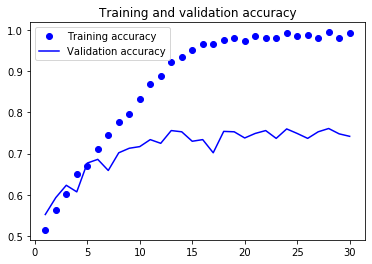

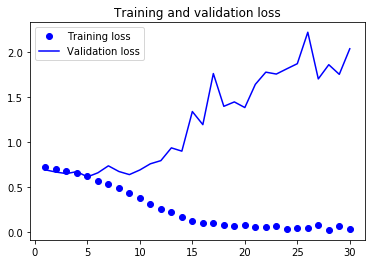

In [11]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

<h5>2.1.7 Test set evaluation </h5>

In this case an accuracy of around 67.5% was reached. Thus, the model model was able to beat the baseline accuracy of 65%. In this case overfitting is the number one consern. To mitigate overfitting data augmentation will be used for the next models as this is hte way to go for computer vision. 

In [12]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 18s 271ms/step - loss: 0.6123 - accuracy: 0.6750
Test accuracy: 0.675


<h5>2.1.8 Data augmentation</h5>

In this case the dataset did not have enough samples to train on, thus it was not able to generalize to new data, meaning it overfit. In order to cope with overfitting the technique of "data augmentation" is used. The approach takes the current samples and transforms them with random augmentations which create similar images. Thus, the model will not see the exact picture twice, but has more chances to train on more aspects of the data so it can generalize better. To do so, data augmentaion layers are added in the beggining of the model. In this case a random flip, rotation and zoom are added to the samples as seen below in the pictures.  

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

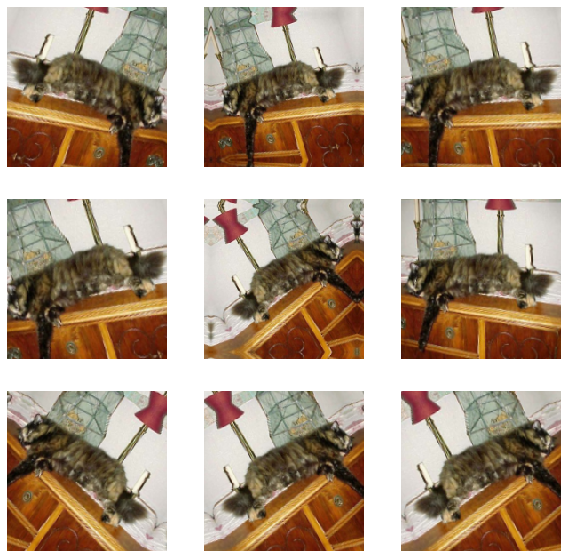

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

As these are not completely different samples we are adding to the dataset, but rather augmentations of a certain sample, it might still lead to overfitting. Hence, a Dropout layer is also added. Also, as overfitting should happen later during training the model is trained for 100 epochs.  

In [15]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy", 
              optimizer="rmsprop",
              metrics=["accuracy"])

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 72s 1s/step - loss: 0.7174 - accuracy: 0.5030 - val_loss: 0.6920 - val_accuracy: 0.5070
Epoch 2/100
63/63 [==============================] - 146s 2s/step - loss: 0.7519 - accuracy: 0.5285 - val_loss: 0.6825 - val_accuracy: 0.5850
Epoch 3/100
63/63 [==============================] - 124s 2s/step - loss: 0.6878 - accuracy: 0.5635 - val_loss: 0.6676 - val_accuracy: 0.5980
Epoch 4/100
63/63 [==============================] - 118s 2s/step - loss: 0.6762 - accuracy: 0.5980 - val_loss: 0.6275 - val_accuracy: 0.6550
Epoch 5/100
63/63 [==============================] - 118s 2s/step - loss: 0.6496 - accuracy: 0.6360 - val_loss: 0.7256 - val_accuracy: 0.5600
Epoch 6/100
63/63 [==============================] - 118s 2s/step - loss: 0.6317 - accuracy: 0.6715 - val_loss: 0.6506 - val_accuracy: 0.5940
Epoch 7/100
63/63 [==============================] - 120s 2s/step - loss: 0.6294 - accuracy: 0.6525 - val_loss: 0.6341 - val_accuracy: 0.6270
Epoch 8

<h5>2.1.9 Displaying accuracy and model evaluation</h5>

In this case one can see that overfitting occures much later, which is good. Compared to the first model which overfit after around the 10th epoch, now the model starts overfitting after the 60-70 epoch. Due to data augmentation and adding of the dropout layer the final accuracy of the model also improved significantly, showing an increase of around 14% from 68% to 83%. This is a significant improvement compared to the first try. 

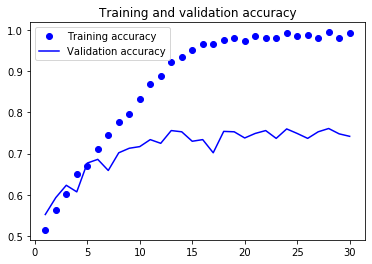

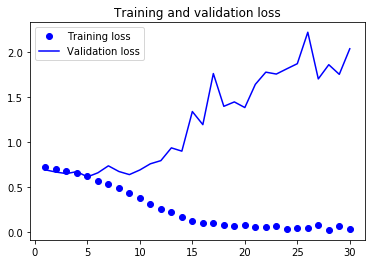

In [16]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [17]:
test_model = keras.models.load_model(
"convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 16s 248ms/step - loss: 0.4798 - accuracy: 0.8300
Test accuracy: 0.830


<h3>2.2 Bigger Model & Experimentation</h3>


As we have a small dataset in this example, it is common to use a pretrained model to increased accuracy. Especially, on large-scale image-classification tasks this works well. For this coursework the VGG16 architecture is used, developed by Karen Simonyan and Andrew Zisserman in 2014. 

<h4>2.2.1 Feature Extraction</h4> 

In this case feature extraction will be used to leverage the pretrained model. Here, representations learned by a previously trained model are used to extract interesting features from new samples. After, the features are run through a calssifier, which is trained from scratch.

Now, the VGG16 model is instantiated and 3 arguments are passed to the constructor: weights, iclude_top and input_shape. After, a summary can be seen of the model. It has 14,714,688 parameters and the final feature map has a shape of (5,5,512). For the following part fast feature extraction without data augmentation will be performed.

In [19]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [20]:
conv_base.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

here the features are extracted as NumPy arrays by calling predict() on the conv_base model on training, validation and testing datasets. As the VGG16 model expects preproceessed inputs, the inputs are scaled pixel values in the appropriate range. The extracted features then have the shape of (samples, 5,5,512)

In [21]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

In [22]:
train_features.shape

(2000, 5, 5, 512)

<h5>2.2.2 Define and Training the classifier (Dropout for Regularization) </h5>

Now, the densly connected classifier is defined and it can be trained on the data and labels that were recorded. In this case a dropout layer is also used for regularization purposes. 

In [23]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy", 
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 3s 42ms/step - loss: 17.5053 - accuracy: 0.9310 - val_loss: 4.7218 - val_accuracy: 0.9680
Epoch 2/20
63/63 [==============================] - 2s 39ms/step - loss: 4.8012 - accuracy: 0.9690 - val_loss: 5.2474 - val_accuracy: 0.9720
Epoch 3/20
63/63 [==============================] - 2s 39ms/step - loss: 2.3085 - accuracy: 0.9875 - val_loss: 8.9276 - val_accuracy: 0.9550
Epoch 4/20
63/63 [==============================] - 3s 41ms/step - loss: 1.8838 - accuracy: 0.9885 - val_loss: 4.4553 - val_accuracy: 0.9760
Epoch 5/20
63/63 [==============================] - 3s 40ms/step - loss: 1.0564 - accuracy: 0.9935 - val_loss: 4.3238 - val_accuracy: 0.9780
Epoch 6/20
63/63 [==============================] - 2s 38ms/step - loss: 0.9338 - accuracy: 0.9925 - val_loss: 7.3575 - val_accuracy: 0.9610
Epoch 7/20
63/63 [==============================] - 2s 38ms/step - loss: 1.5289 - accuracy: 0.9905 - val_loss: 4.6205 - val_accuracy: 0.9780
Epoch 8/20
6

<h5>2.2.3 Plotting results</h5>

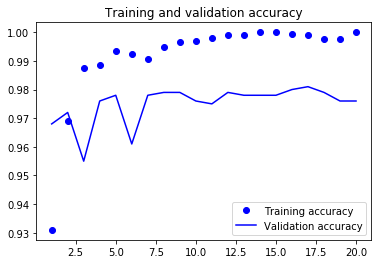

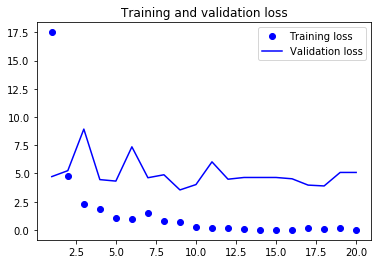

In [24]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")

plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

<h5>2.2.4 Evaluation Results </h5>

In this case, the accuracy is around 97% which is again a strong improvement to the previous model that we trained. However, it must be said that this comparison is not totally fair as the pretrained model contains much more dog and cat instances. However, this is not always the case for pretrained models. Also, in this case overfitting starts very early, which can further be improved by using data augmentation as it helps to prevent overfitting for small datasets.

In [25]:
test_model = keras.models.load_model(
"feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels )
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 0s 5ms/step - loss: 6.1189 - accuracy: 0.9730
Test accuracy: 0.973


<h1>3. Results & Conclusion</h1>

This final part should summarize and conclude the second Neural Network Coursework. Even though for each section results have already been shown, they should quickly be summarized in this part as well. Also, a full conclusion will be given that shows the workings of this notebook. 

Firstly, this notebook started by importing the cats and dogs dataset. Then, the cats and dogs dataset was split up into a smaller dataset in order to simulate more of a real world problem where one does not have too many sample images. Also, the compute power required would not be as high as with a full dataset as less parameters would be learned. The dataset was split into a training set with 1000 samples, a validation set with 500 samples and a test set with 1000 samples. After, a small model was created with the aim to beat the baseline performance metric of 65%. This first model was rather small with only 991,041 parameters and alternating Conv2D and MaxPooling layers. The model achieved an accuracy of around 67.5%, beating the baseline. 

Further Data augmentation was added in order to increase the number of samples for the model. The model was trained for 100 epochs and it overfitting was identified after around 60-70 epochs. The model accuracy increased from around 68% to almost 83% which is a big improvement of around 14%. Thus, through data augmentation it was already possible to improve the model from the first try. 

Later, a bigger model was trained. As the dataset was small a pretrained model was added. In this case the VGG16 architecture was used. To leverage the pretrained model, feature extraction was used. The model had a total of 14,714,688 parameters. Also, Dropout was used for regularization purposes. After plotting the results, the accuracy improved another 14% from 83% to 97%. Again, here the bigger model clearly outperformed all models before. 97% is already a very good classification rate for such a problem without too many samples. Moreover, this model could be improved even further with more computing power if data augmentation is used. However, as this project was done locally, this step was currently not performed. It must be stated that this coursework was an attempt to mimic a real world situation with a small dataset and perhaps no access to too much computing power. For this case one could say the the improvement is significant from a first model that achieved only 67.5% barely beating the baseline, to a bigger model which achieved over 97% accuracy. 

As for further work which are outside the scope for this coursework, one might try to train an even bigger model, apply data augmentation with more computing power and improve the composition of layers perhaps. Nevertheless, overall this model is suitable for a good accuracy to identify cats versus dogs from a small dataset and shows the workflow of the topics 5-8 techniques using a convnet for a computer vision task. It was shown that overfitting is the main issue with a small dataset and data augmentation is a great wa to fight overfitting for image data. Also, it can be said that the existing convnet can easily be reused on a new dataset via feature extraction. Further, fine tuning could be applied for more experimentation and further research directions. 

